In [15]:
import gym
import sys
import numpy as np

from gym import error, spaces, utils
from copy import deepcopy

import matplotlib.pyplot as plt
import collections

from tqdm import tqdm

In [16]:
class CliffWalkingEnv(gym.Env):
    """
    A simplified implementation of the cliffwalking environment from 
    Sutton & Barto (e.g., Figure 6.13)

    The board is a 4x12 matrix, with (using NumPy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    """

    def observation(self, state):
        return state[0] * self.cols + state[1]

    def __init__(self, render_steps = False):
        self.env_shape = (4, 12) # attributes like these are added for convenience
        # (i.e., so it's easy to refer to these values in various methods)
        self.rows = 4
        self.cols = 12
        self.start = [3,0] # row, col of our start position
        self.goal = [3,11] # row, col of our terminal state
        self.current_state = self.start 
        self.render_steps = render_steps

        # Cliff location
        self._cliff = np.zeros(self.env_shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True 

        # There are four actions: up, down, left and right
        # Note that the state space gym.spaces.Discrete is a custom class
        # in the gym library.
        self.action_space = spaces.Discrete(4)

        # observation is the x, y coordinate of the grid
        # Note the state space is the same custom class.
        self.observation_space = spaces.Discrete(self.rows*self.cols)


    def step(self, action):
        """
        Take a step in the cliffwalking environment.

        INPUT
          action : integer (0,3) : right (0), down (1), left (2), and up (3).
        OUTPUT
          observation : A special class representing the x,y on the grid.
          reward : float : The reward received following the action.
          terminal_state : boolean : Has the terminal state been reached?
        """
        new_state = deepcopy(self.current_state)

        if action == 0: #right, "min" ensures you can't go through a wall,
          # and just end up back in your previous state.
            new_state[1] = min(new_state[1]+1, self.cols-1)
        elif action == 1: #down, "max" ensures you can't go through a wall.
            new_state[0] = max(new_state[0]-1, 0)
        elif action == 2: #left
            new_state[1] = max(new_state[1]-1, 0)
        elif action == 3: #up
            new_state[0] = min(new_state[0]+1, self.rows-1)
        else:
            raise Exception("Invalid action.")

        # Update our state
        self.current_state = new_state

        if self.render_steps:
          self.render()

        reward = -1.0
        terminal_state = False
        if self.current_state[0] == 3 and self.current_state[1] > 0:
            if self.current_state[1] < self.cols - 1:
                reward = -100.0
                self.current_state = deepcopy(self.start)
            else:
                terminal_state = True

        # IMPORTANT: The step() method needs to return these 4 things in this order.
        # The new state, the reward, "is this episode over?" boolean", 
        # and an "info dictionary" for debugging purposes if you want to use it. 
        # I leave it empty.  
        return self.observation(self.current_state), reward, terminal_state, {}

    def reset(self):
        self.current_state = self.start
        return self.observation(self.current_state)
    
    def show_env(self):
      """
      Shows the environment.
      """
      gridworld = np.ndarray((self.rows,self.cols), dtype = 'object')

      for row in np.arange(self.rows):
        for col in np.arange(self.cols):

          if self.current_state == [row,col]:
            gridworld[row,col] = "x"
          elif [row,col] == self.goal:
              gridworld[row,col] = "T"
          elif self._cliff[row,col]:
              gridworld[row,col] = "C"
          else:
              gridworld[row,col] = "o"

      print(gridworld)


    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
      """
      render function from:
      https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py

      I admit I don't have much experience with rendering with characters. On face,
      this works the same as what I made.
      """
      if close:
        return

      outfile = StringIO() if mode == 'ansi' else sys.stdout

      for s in range(self.rows*self.cols):
            position = np.unravel_index(s, self.env_shape)
            # print(self.s)
            if self.current_state == s:
                output = " x "
            elif position == (3,11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.env_shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
      outfile.write("\n")

    def close(self):
        pass

In [17]:
class Q_learning_agent(object):
    def __init__(self, obs_n, act_n = 4, learning_rate=0.01, gamma=0.9, e_greed=0.1):
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = e_greed
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))
        
        info = "Q_LearningAgent with state number = " +  str(obs_n) + ", learning rate = " + str(learning_rate) + ", gamma = " + str(gamma) + " created."
        print(info)
    
    def sample(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action
        
    def learn(self, S, action, reward, S_prime, action_prime, done):
        predit_Q = self.Q[S, action]

        if (done):
            target_Q = reward
        else:
            target_Q = reward + self.gamma * np.max(self.Q[S_prime])

        self.Q[S, action] += self.lr * (target_Q - predit_Q)

In [18]:
class SarsaAgent(object):
    def __init__(self, obs_n, act_n = 4, learning_rate=0.01, gamma=0.9, e_greed=0.1):
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = e_greed
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))
        
        info = "Sarsa Agent with state number = " +  str(obs_n) + ", learning rate = " + str(learning_rate) + ", gamma = " + str(gamma) + " created."
        print(info)

    def sample(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action

    def learn(self, S, action, reward, S_prime, action_prime, done):
        predit_Q = self.Q[S, action]

        if (done):
            target_Q = reward
        else:
            target_Q = reward + self.gamma * self.Q[S_prime, action_prime]

        self.Q[S, action] += self.lr * (target_Q - predit_Q)
    

In [19]:
def run_episode(env, agent):
    S = env.reset()
    action = agent.sample(S)
    
    total_reward = 0
    while (True):
        S_prime, reward, done, _ = env.step(action)
        action_prime = agent.sample(S_prime)

        agent.learn(S, action, reward, S_prime, action_prime, done)

        action = action_prime
        S = S_prime
        total_reward += reward

        if done:
            break
    
    return total_reward

In [20]:
def main():
    env = CliffWalkingEnv()

    q_agent = Q_learning_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n, 
        learning_rate=0.5, gamma = 1, e_greed=0.1)

    sarsa_agent = SarsaAgent(obs_n=env.observation_space.n,  act_n=env.action_space.n, 
        learning_rate=0.5, gamma = 1, e_greed=0.1)

    q_reward_history = []
    sarsa_reward_history = []

    for i in range(20):
        q_reward_list = []
        sarsa_reward_list = []

        for episode in range(500):
            q_reward = run_episode(env, q_agent)
            q_reward_list.append(q_reward)

            sarsa_reward = run_episode(env, sarsa_agent)
            sarsa_reward_list.append(sarsa_reward)

        q_reward_history.append(q_reward_list)
        sarsa_reward_history.append(sarsa_reward_list)

    q_reward_history = np.array(q_reward_history)
    sarsa_reward_history = np.array(sarsa_reward_history)

    q_avg = q_reward_history.sum(axis=0)/20
    sarsa_avg = sarsa_reward_history.sum(axis=0)/20

    return q_avg, sarsa_avg

In [21]:
q_avg, sarsa_avg = main()

Q_LearningAgent with state number = 48, learning rate = 0.5, gamma = 1 created.
Sarsa Agent with state number = 48, learning rate = 0.5, gamma = 1 created.


In [22]:
q_avg_rewards = []
sarsa_avg_rewards = []
for i in range(14):
    q_avg_rewards.append(np.mean(q_avg[:i+1]))
    sarsa_avg_rewards.append(np.mean(sarsa_avg[:i+1]))
for i in range(15,len(q_avg)+1):
    q_avg_rewards.append(np.mean(q_avg[i-15:i]))
    sarsa_avg_rewards.append(np.mean(sarsa_avg[i-15:i]))


Text(0, 0.5, 'Sum of rewards during episode')

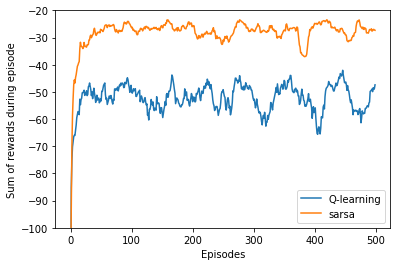

In [23]:
plt.plot(range(0,500), q_avg_rewards, label="Q-learning")
plt.plot(range(0,500), sarsa_avg_rewards,label="sarsa")
plt.ylim((-100,-20))
plt.legend(loc="lower right")
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")

In [24]:
class monte_carlo_agent(object):
    def __init__(self, obs_n, act_n, gamma, epsilon):
        self.gamma = gamma
        self.epsilon = epsilon
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))

    def policy(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action

    def learn(self, total_returns, num_visits, state, action):
        self.Q[state, action] = total_returns[state, action] / num_visits[state]
    
        

In [25]:
def monte_carlo():

    mc_reward_history = []
    for i in range(20):
        env = CliffWalkingEnv()
        mc_agent = monte_carlo_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n,  gamma = 1, epsilon=0.1)
        gamma = 0.8

        rewards_list = []
        total_returns = np.zeros((env.observation_space.n, env.action_space.n))
        num_visits = np.zeros(env.observation_space.n)

        for episode in range(500):
            trajectory = []
            S = env.reset()
            action = mc_agent.policy(S)

            total_reward = 0
            while(True):
                S_prime, reward, done, _ = env.step(action)
                trajectory.append((S, action, reward))
                action_prime = mc_agent.policy(S_prime)

                S = S_prime
                action = action_prime
                total_reward += reward 
                if done:
                    break
            
            rewards_list.append(total_reward)
            previous_reward = 0
            for state, action, reward in trajectory:
                total_returns[state, action] += (reward + gamma * previous_reward)
                num_visits[state] += 1
                mc_agent.learn(total_returns, num_visits, state, action)

        mc_reward_history.append(rewards_list)

    mc_reward_history = np.array(mc_reward_history)

    mc_avg = mc_reward_history.sum(axis=0)/20
    return mc_avg

In [26]:
mc_avg = monte_carlo()

In [27]:
mc_rewards = []
for i in range(14):
    mc_rewards.append(np.mean(mc_avg[:i+1]))

for i in range(15,len(q_avg)+1):
    mc_rewards.append(np.mean(mc_avg[i - 15:]))


(-10000.0, 0.0)

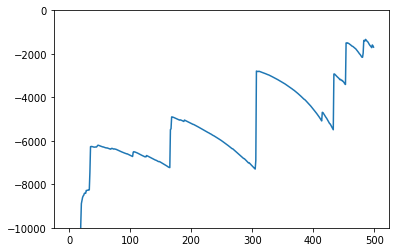

In [33]:
plt.plot(range(0,500), mc_rewards)
plt.ylim((-10000,0))